In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

In [18]:
dataset = pd.read_csv('./data/creditcard.csv')

# Shuffling the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,97015.0,2.129291,0.277413,-1.909965,0.272202,0.531520,-1.782837,0.762328,-0.733091,1.415811,...,0.005522,0.431423,-0.037343,0.057855,0.429297,0.197291,-0.110171,-0.083557,6.71,0
1,66718.0,-1.292607,0.531617,2.211670,1.216904,-1.643366,0.098611,0.483296,0.505464,-0.332100,...,0.237570,0.297245,0.311425,0.682967,0.280958,-0.290464,-0.071516,0.048963,219.14,0
2,126288.0,2.332456,-1.288351,-1.166183,-1.642709,-0.930003,-0.498576,-1.016586,-0.222232,-1.287503,...,-0.190227,-0.034218,0.222645,0.466242,-0.094541,-0.179290,0.006181,-0.046532,15.00,0
3,121289.0,1.925714,-0.014820,-1.945133,0.976264,1.273994,0.873284,0.235924,0.216289,0.114380,...,0.120087,0.615778,0.002280,-1.650688,0.285518,-0.376703,0.022899,-0.092023,1.00,0
4,112348.0,-0.028788,0.962480,-0.576597,-0.741388,1.126978,-0.338704,0.816764,0.044424,-0.154922,...,-0.303439,-0.814155,0.094659,0.164797,-0.417124,0.106910,0.085464,0.062983,1.79,0


In [ ]:
# Preprocessing
labels = dataset['Class']
unsupervised_df = dataset.drop(columns=['Class'])

# Normalizing
scaler = MinMaxScaler(feature_range=(0, 1))
unsupervised_data = scaler.fit_transform(unsupervised_df)

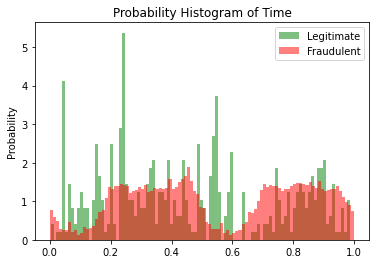

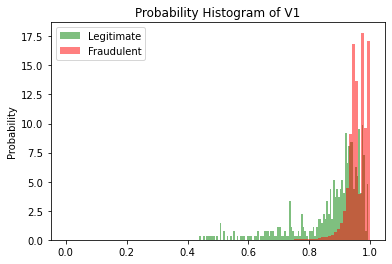

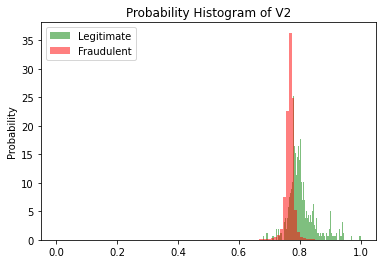

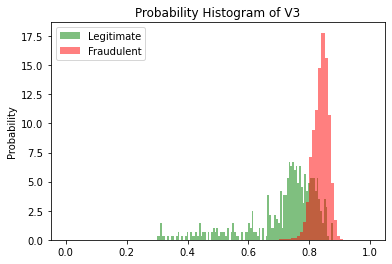

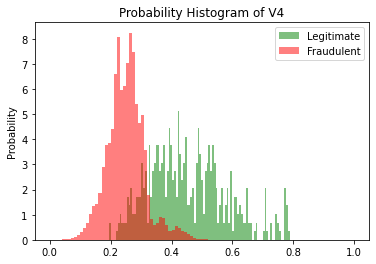

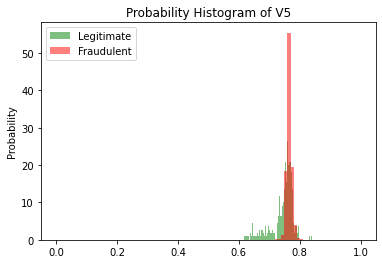

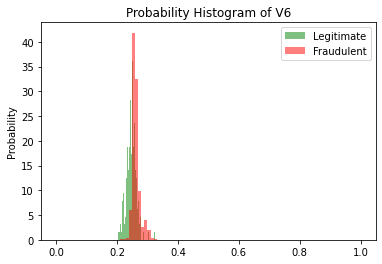

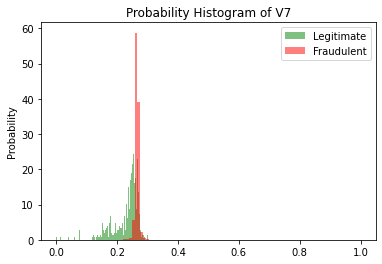

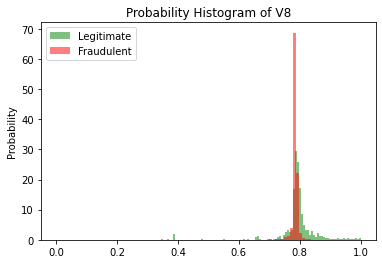

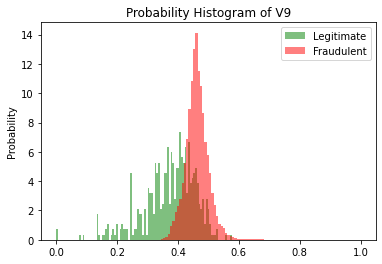

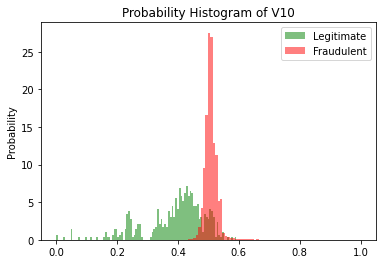

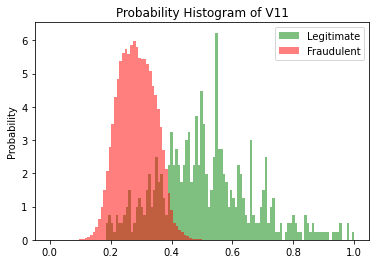

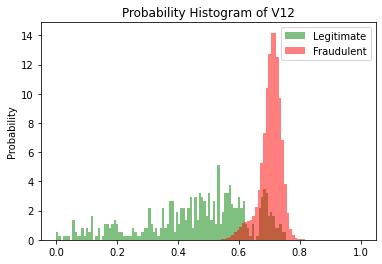

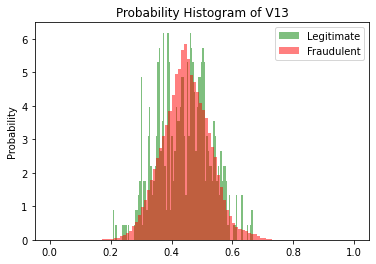

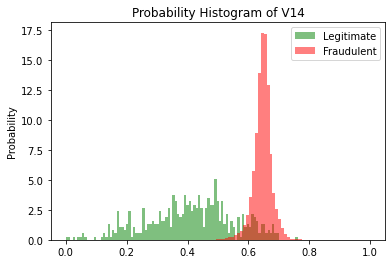

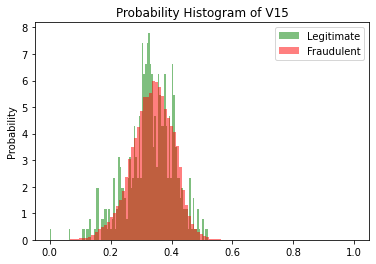

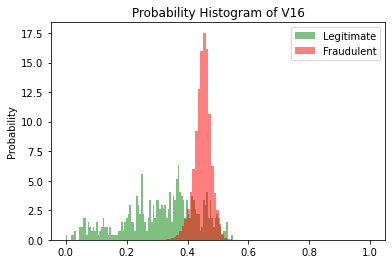

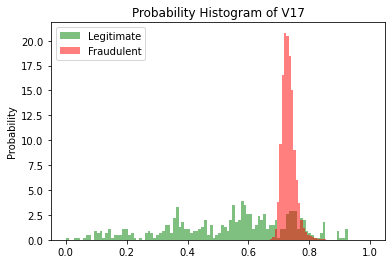

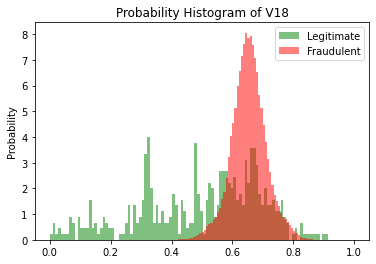

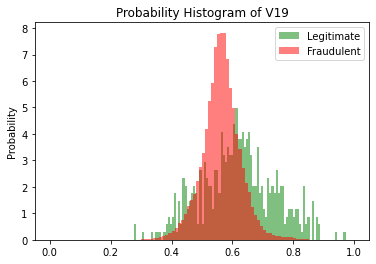

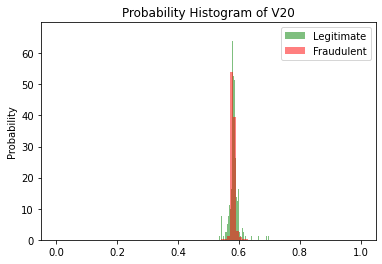

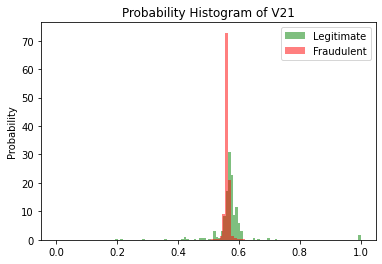

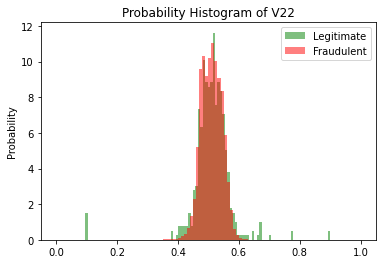

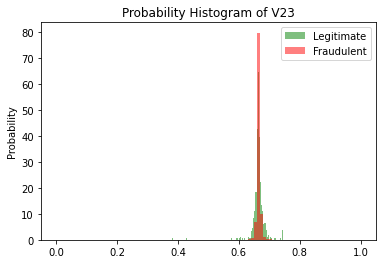

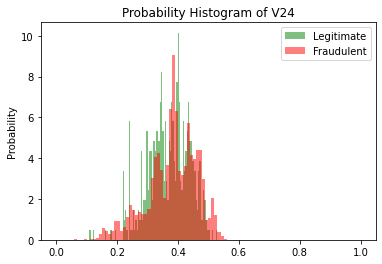

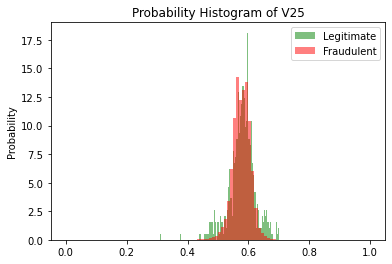

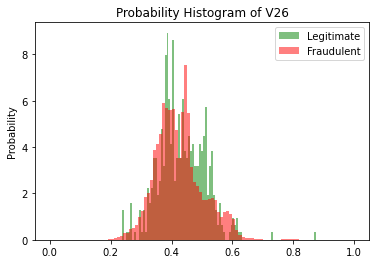

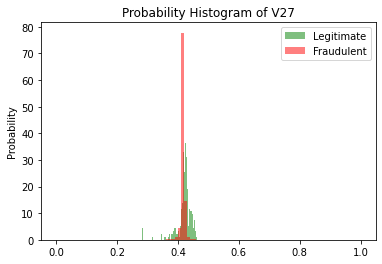

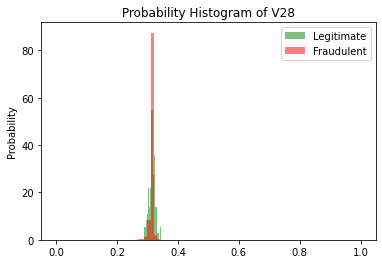

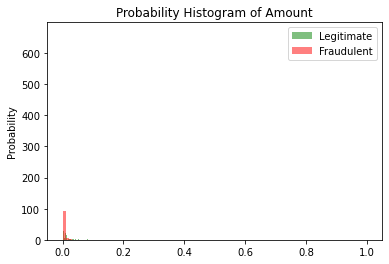

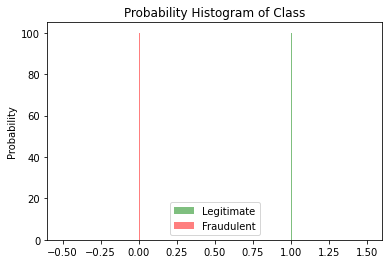

In [33]:
normalized_Dataset = (dataset-dataset.min()) / (dataset.max()-dataset.min())
for Feature in normalized_Dataset:
    legitimate = normalized_Dataset.loc[dataset.Class == 1, Feature]
    fraudulent = normalized_Dataset.loc[dataset.Class == 0, Feature]

    kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

    plt.hist(legitimate, **kwargs, color='Green', label='Legitimate')
    plt.hist(fraudulent, **kwargs, color='Red', label='Fraudulent')
    plt.gca().set(title='Probability Histogram of ' + str(Feature), ylabel='Probability')
    plt.legend()
    plt.show()

In [20]:
# Kfold validation
X = unsupervised_df.to_numpy()
y = np.array(labels)
k_fold = 10
accuracies_train = []
accuracies_test = []
spacing = round(X.shape[0] / k_fold)
for k in range(k_fold):
    lower = k * spacing
    upper = (k + 1) * spacing
    x_train = np.concatenate((X[0: lower][:], X[upper:][:]))
    y_train = np.concatenate((y[0: lower], y[upper:]))
    x_test = X[lower: upper]
    y_test = y[lower: upper]

    # Initializing and running Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2)
    prediction_train = gmm.fit_predict(x_train)
    train_accuracy = np.count_nonzero(prediction_train == y_train) / len(prediction_train)
    accuracies_train.append(train_accuracy)
    prediction_test = gmm.predict(x_test)
    test_accuracy = np.count_nonzero(prediction_test == y_test) / len(prediction_test)
    accuracies_test.append(test_accuracy)

print(np.mean(accuracies_train), np.mean(accuracies_test))

0.5400408406585396 0.5406794449090406


In [16]:
# Evaluating definition of clusters
train_silhouette_score = silhouette_score(x_train, prediction_train)
test_silhouette_score = silhouette_score(x_test, prediction_test)

print(f'Silhouette score on train data = {train_silhouette_score}')
print(f'Silhouette score on test data = {test_silhouette_score}')

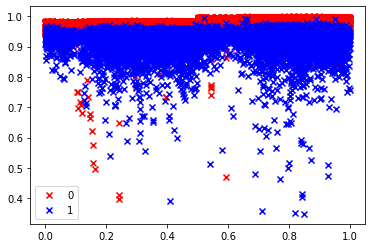

In [23]:
# Plotting based on test

toPlotMal = x_test[prediction_test == 0]
toPlotBen = x_test[prediction_test == 1]

plt.scatter(toPlotMal[:, 0], toPlotMal[:, 1], c = "red", marker = 'x', label = "0")
plt.scatter(toPlotBen[:, 0], toPlotBen[:, 1], c = "blue", marker = 'x', label = "1")
plt.legend()
plt.show()